In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [8]:
df = pd.read_excel('/content/indicadores_CT.xlsx')

df.head()

,unidade,cod_curso_ufc,cod_curso_inep,curso,habilitacao,modalidade,grau,turno,cota,num_nota_geral_cs,...,tipo_ingresso,matricula,nome,status_aluno_atual,tipo_ocorrencia,ano_referencia,periodo_referencia,Observação do cancelamento2,id_discente,teve_historico
0,CT,4,13987,ARQUITETURA E URBANISMO,NaN,Presencial,BACHARELADO,Matutino e Vespertino,NaN,NaN,...,SELEÇÃO SISU,276017,AMANDA LEAL MAIA,CANCELADO,CANCELAMENTO POR ABANDONO,2013.0,2.0,Discente não cumpriu os requisitos para manute...,45776,sim
1,CT,4,13987,ARQUITETURA E URBANISMO,NaN,Presencial,BACHARELADO,Matutino e Vespertino,NaN,NaN,...,MUDANCA DE CURSO,285688,MARIA GISELA PARENTE NASCIMENTO DE LIMA,CONCLUÍDO,CONCLUSÃO,2016.0,1.0,NaN,45923,sim
2,CT,4,13987,ARQUITETURA E URBANISMO,NaN,Presencial,BACHARELADO,Matutino e Vespertino,NaN,NaN,...,VESTIBULAR,286440,FRANCISCO WALTER MAGALHÃES DE VASCONCELOS,CANCELADO,CANCELAMENTO POR ABANDONO,2015.0,1.0,Discente não cumpriu os requisitos para manute...,45924,sim
3,CT,4,13987,ARQUITETURA E URBANISMO,NaN,Presencial,BACHARELADO,Matutino e Vespertino,NaN,NaN,...,SELEÇÃO SISU,301964,GERMANA BRAGA REGO,CANCELADO,DESISTÊNCIA,2011.0,2.0,NaN,45941,sim
4,CT,4,13987,ARQUITETURA E URBANISMO,NaN,Presencial,BACHARELADO,Matutino e Vespertino,NaN,NaN,...,VESTIBULAR,319808,MATHEUS AGUIAR COELHO,CONCLUÍDO,CONCLUSÃO,2016.0,1.0,NaN,45948,sim


Então a "coorte" nos gráficos vai mostrar:

Quantos desses alunos se mantiveram (TAP) ao longo dos anos

Quantos concluíram (TCA) ao longo dos anos

Quantos desistiram/transferiram (TDA) ao longo dos anos
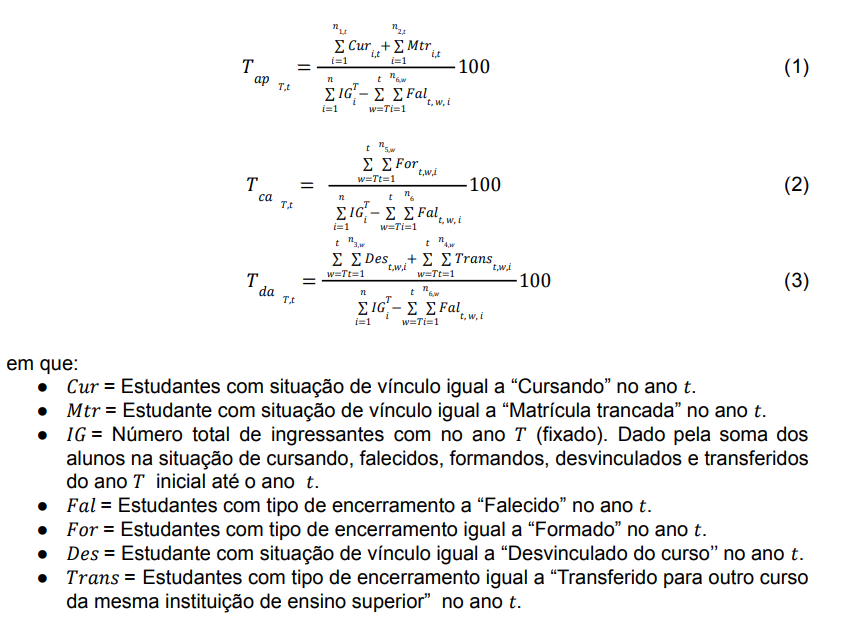

Para calcular as taxas TAP, TCA e TDA, precisamos adaptar as variáveis conforme as definições:

IGT: número de ingressantes no ano T → virá de ingressantes.

Cur e Mtr: alunos cursando ou com matrícula trancada → virá de ingressantes.

Fal: alunos cancelados por falecimento → virá de cancelados.

For: alunos que concluíram → virá de concluidos.

Des: alunos cancelados por desistência → cancelados com tipo Desistência ou equivalente.

Trans: alunos que foram transferidos → cancelados com tipo Transferência ou equivalente.

In [ ]:
Meu TAP está zerado porque a base não tem linhas CURSANDO por ano no df_ingressantes → normal!

In [59]:
# Função para calcular TAP - Taxa de permanência
def calcular_TAP(df_ingressantes, df_cancelados, ano_T, ano_t, mostrar=True):
    IG_T = df_ingressantes[df_ingressantes['ano_ingresso'] == ano_T]['id_discente'].nunique()

    mask_cursando = (
        (df_ingressantes['ano_ingresso'] == ano_T) &
        (df_ingressantes['ano_referencia'] == ano_t) &
        (df_ingressantes['status_aluno_atual'].isin(['CURSANDO', 'MATRÍCULA TRANCADA']))
    )
    Cur_Mtr = df_ingressantes[mask_cursando]['id_discente'].nunique()

    mask_falecidos = (
        (df_cancelados['ano_ingresso'] >= ano_T) &
        (df_cancelados['ano_referencia'] <= ano_t) &
        (df_cancelados['tipo_ocorrencia'].str.contains('FALECIDO', case=False, na=False))
    )
    Fal = df_cancelados[mask_falecidos]['id_discente'].nunique()

    denominador = IG_T - Fal
    TAP = (Cur_Mtr / denominador) * 100 if denominador > 0 else 0

    if mostrar:
        print(f"Taxa de Permanência (TAP) para ingresso {ano_T}, análise {ano_t}: {TAP:.2f} %")

    return TAP

# Exemplo
calcular_TAP(df_ingressantes, df_cancelados, ano_T=2015, ano_t=2017)

Taxa de Permanência (TAP) para ingresso 2015, análise 2017: 0.00 %


0.0

In [60]:
# Cálculo da TCA - Taxa de Conclusão
def calcular_TCA(df_ingressantes, df_concluidos, df_cancelados, ano_T, ano_t, mostrar=True):
    # Coorte de ingressantes no ano T
    ingressantes_T_ids = df_ingressantes[df_ingressantes['ano_ingresso'] == ano_T]['id_discente'].unique()
    IG_T = len(ingressantes_T_ids)

    # Quantos desses alunos concluíram entre anos T e t
    mask_formados = (
        (df_concluidos['ano_conclusao'] >= ano_T) &
        (df_concluidos['ano_conclusao'] <= ano_t) &
        (df_concluidos['id_discente'].isin(ingressantes_T_ids))
    )
    For = df_concluidos[mask_formados]['id_discente'].nunique()

    # Quantos desses faleceram entre T e t
    mask_falecidos = (
        (df_cancelados['ano_referencia'] >= ano_T) &
        (df_cancelados['ano_referencia'] <= ano_t) &
        (df_cancelados['tipo_ocorrencia'].str.contains('FALECIDO', case=False, na=False)) &
        (df_cancelados['id_discente'].isin(ingressantes_T_ids))
    )
    Fal = df_cancelados[mask_falecidos]['id_discente'].nunique()

    denominador = IG_T - Fal
    TCA = (For / denominador) * 100 if denominador > 0 else 0

    if mostrar:
        print(f"Taxa de Conclusão (TCA) para ingresso {ano_T}, análise {ano_t}: {TCA:.2f} %")

    return TCA

In [61]:
_ = calcular_TCA(df_ingressantes, df_concluidos, df_cancelados, ano_T=2015, ano_t=2017)

Taxa de Conclusão (TCA) para ingresso 2015, análise 2017: 31.09 %


In [62]:
# Cálculo da TDA - Taxa de Desistência

def calcular_TDA(df_ingressantes, df_cancelados, ano_T, ano_t, mostrar=True):
    # Coorte de ingressantes no ano T
    ingressantes_T_ids = df_ingressantes[df_ingressantes['ano_ingresso'] == ano_T]['id_discente'].unique()
    IG_T = len(ingressantes_T_ids)

    # Quantos desses desistiram ou transferiram entre anos T e t
    mask_desistentes = (
        (df_cancelados['ano_referencia'] >= ano_T) &
        (df_cancelados['ano_referencia'] <= ano_t) &
        (
            df_cancelados['tipo_ocorrencia'].str.contains('DESIST', case=False, na=False) |
            df_cancelados['tipo_ocorrencia'].str.contains('TRANSFER', case=False, na=False)
        ) &
        (df_cancelados['id_discente'].isin(ingressantes_T_ids))
    )
    Des_Trans = df_cancelados[mask_desistentes]['id_discente'].nunique()

    # Quantos desses faleceram entre T e t
    mask_falecidos = (
        (df_cancelados['ano_referencia'] >= ano_T) &
        (df_cancelados['ano_referencia'] <= ano_t) &
        (df_cancelados['tipo_ocorrencia'].str.contains('FALECIDO', case=False, na=False)) &
        (df_cancelados['id_discente'].isin(ingressantes_T_ids))
    )
    Fal = df_cancelados[mask_falecidos]['id_discente'].nunique()

    denominador = IG_T - Fal
    TDA = (Des_Trans / denominador) * 100 if denominador > 0 else 0

    if mostrar:
        print(f"Taxa de Desistência (TDA) para ingresso {ano_T}, análise {ano_t}: {TDA:.2f} %")

    return TDA

In [63]:
_ = calcular_TDA(df_ingressantes, df_cancelados, ano_T=2015, ano_t=2017)

Taxa de Desistência (TDA) para ingresso 2015, análise 2017: 5.44 %


In [64]:
def gerar_dataframe_consolidado(df_ingressantes, df_concluidos, df_cancelados, coortes, max_anos_permanencia=8):
    resultados = {
        'Coorte': [],
        'Ano de Permanência': [],
        'TAP (%)': [],
        'TCA (%)': [],
        'TDA (%)': []
    }

    for ano_T in coortes:
        # Verificar se existe coorte com alunos
        ingressantes_T_ids = df_ingressantes[df_ingressantes['ano_ingresso'] == ano_T]['id_discente'].unique()
        IG_T = len(ingressantes_T_ids)

        if IG_T == 0:
            print(f">>> Coorte {ano_T}: SEM ingressantes — pulando.")
            continue

        print(f">>> Coorte {ano_T}: {IG_T} ingressantes.")

        # Definir anos de análise para esta coorte
        anos_analise = list(range(ano_T, ano_T + max_anos_permanencia))

        # Calcular indicadores para esta coorte
        for ano_t in anos_analise:
            tap = calcular_TAP(df_ingressantes, df_cancelados, ano_T, ano_t, mostrar=False)
            tca = calcular_TCA(df_ingressantes, df_concluidos, df_cancelados, ano_T, ano_t, mostrar=False)
            tda = calcular_TDA(df_ingressantes, df_cancelados, ano_T, ano_t, mostrar=False)

            resultados['Coorte'].append(ano_T)
            resultados['Ano de Permanência'].append(ano_t - ano_T + 1)
            resultados['TAP (%)'].append(tap)
            resultados['TCA (%)'].append(tca)
            resultados['TDA (%)'].append(tda)

    df_consolidado = pd.DataFrame(resultados)
    return df_consolidado

In [65]:
# Defina as coortes e o máximo de anos de permanência
coortes = list(range(2011, 2019))
max_anos_permanencia = 8

# Chame a função e armazene o DataFrame em df_consolidado
df_consolidado = gerar_dataframe_consolidado(df_ingressantes, df_concluidos, df_cancelados, coortes, max_anos_permanencia)

>>> Coorte 2011: 85 ingressantes.
>>> Coorte 2012: 239 ingressantes.
>>> Coorte 2013: 328 ingressantes.
>>> Coorte 2014: 410 ingressantes.
>>> Coorte 2015: 846 ingressantes.
>>> Coorte 2016: 726 ingressantes.
>>> Coorte 2017: 851 ingressantes.
>>> Coorte 2018: 871 ingressantes.


In [66]:
print(df_consolidado)

    Coorte  Ano de Permanência  TAP (%)    TCA (%)    TDA (%)
0     2011                   1      0.0   1.176471  25.882353
1     2011                   2      0.0   1.176471  27.058824
2     2011                   3      0.0   1.176471  27.058824
3     2011                   4      0.0   1.176471  27.058824
4     2011                   5      0.0   1.176471  27.058824
..     ...                 ...      ...        ...        ...
59    2018                   4      0.0  52.238806   5.396096
60    2018                   5      0.0  52.238806   5.396096
61    2018                   6      0.0  52.238806   5.396096
62    2018                   7      0.0  52.238806   5.396096
63    2018                   8      0.0  52.238806   5.396096

[64 rows x 5 columns]


TAP = taxa de permanência

TCA = taxa de conclusão

TDA = taxa de desistência

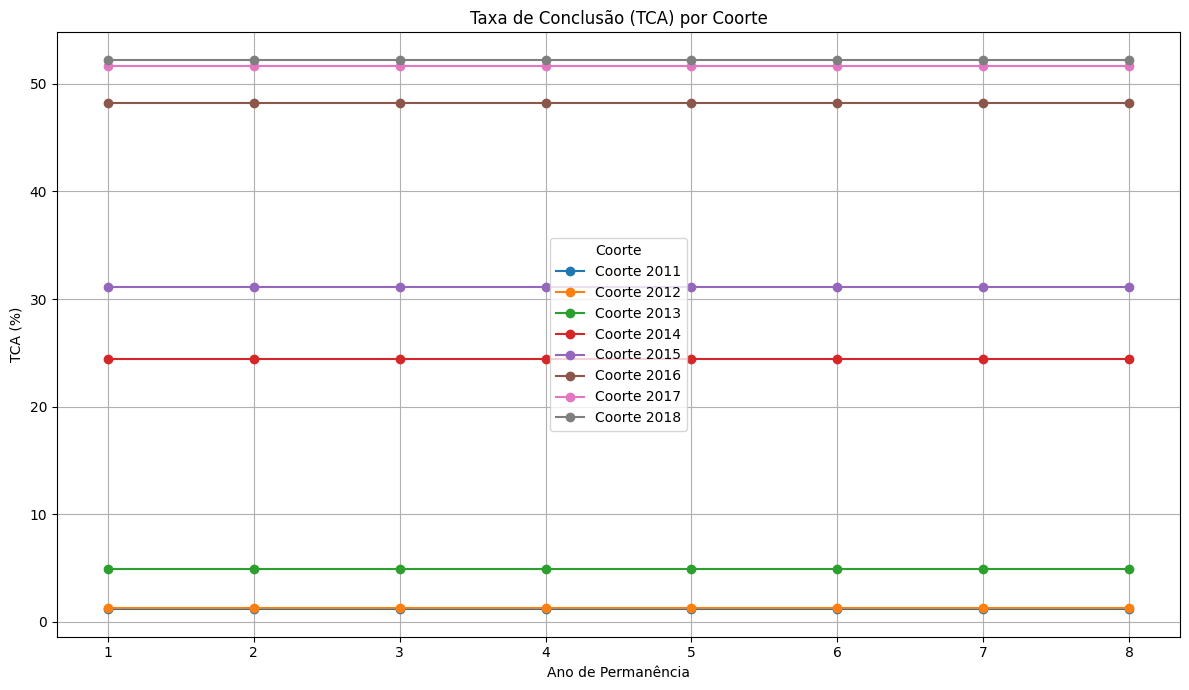

In [67]:
# Gráfico consolidado para TCA
plt.figure(figsize=(12,7))

for coorte in df_consolidado['Coorte'].unique():
    df_coorte = df_consolidado[df_consolidado['Coorte'] == coorte]
    plt.plot(df_coorte['Ano de Permanência'], df_coorte['TCA (%)'], marker='o', label=f'Coorte {coorte}')

plt.xlabel('Ano de Permanência')
plt.ylabel('TCA (%)')
plt.title('Taxa de Conclusão (TCA) por Coorte')
plt.legend(title='Coorte')
plt.grid(True)
plt.tight_layout()
plt.show()

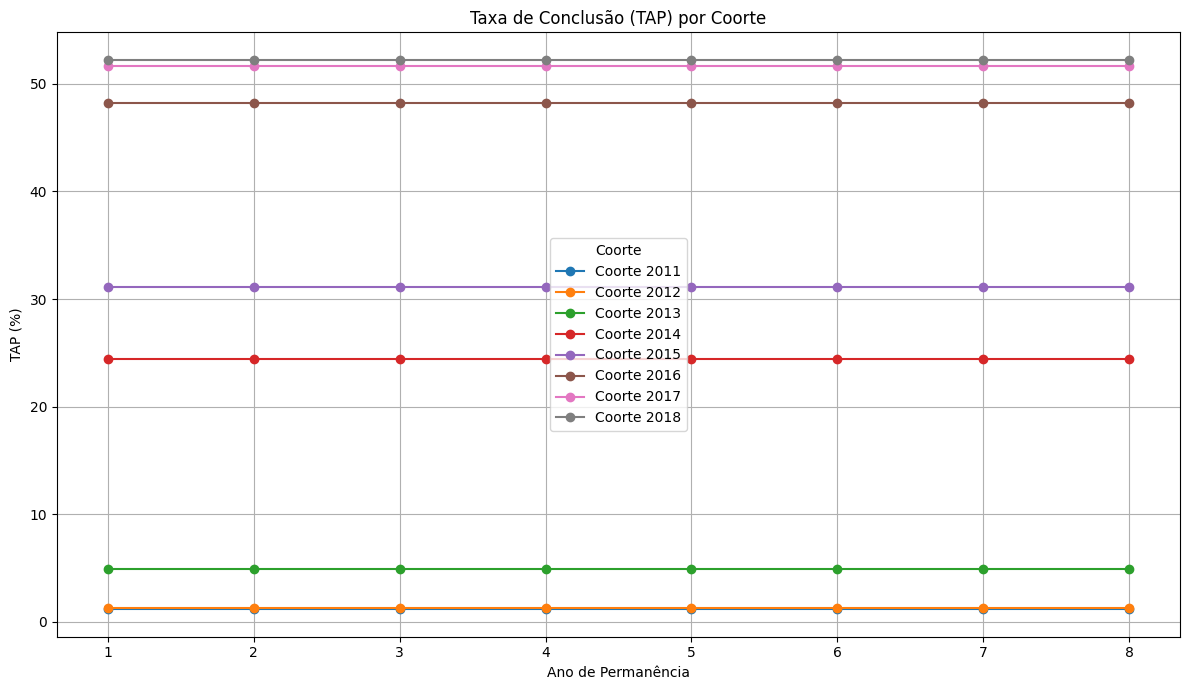

In [68]:
# Gráfico consolidado para TAP
plt.figure(figsize=(12,7))

for coorte in df_consolidado['Coorte'].unique():
    df_coorte = df_consolidado[df_consolidado['Coorte'] == coorte]
    plt.plot(df_coorte['Ano de Permanência'], df_coorte['TCA (%)'], marker='o', label=f'Coorte {coorte}')

plt.xlabel('Ano de Permanência')
plt.ylabel('TAP (%)')
plt.title('Taxa de Conclusão (TAP) por Coorte')
plt.legend(title='Coorte')
plt.grid(True)
plt.tight_layout()
plt.show()

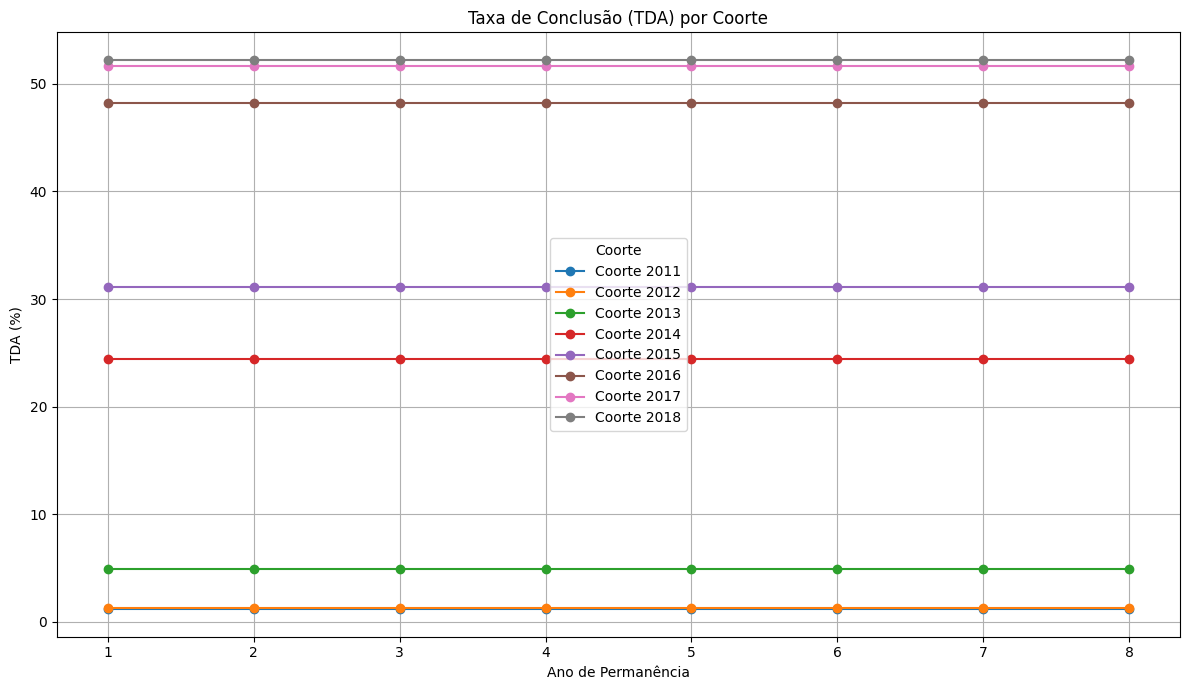

In [69]:
# Gráfico consolidado para TDA
plt.figure(figsize=(12,7))

for coorte in df_consolidado['Coorte'].unique():
    df_coorte = df_consolidado[df_consolidado['Coorte'] == coorte]
    plt.plot(df_coorte['Ano de Permanência'], df_coorte['TCA (%)'], marker='o', label=f'Coorte {coorte}')

plt.xlabel('Ano de Permanência')
plt.ylabel('TDA (%)')
plt.title('Taxa de Conclusão (TDA) por Coorte')
plt.legend(title='Coorte')
plt.grid(True)
plt.tight_layout()
plt.show()

In [71]:
sns.set(style="whitegrid")

# Função para gráfico de barras
def plot_barras(df_consolidado, variavel, titulo):
    plt.figure(figsize=(12,7))
    sns.barplot(
        data=df_consolidado,
        x='Ano de Permanência',
        y=variavel,
        hue='Coorte'
    )
    plt.title(titulo)
    plt.xlabel('Ano de Permanência')
    plt.ylabel(variavel)
    plt.legend(title='Coorte')
    plt.tight_layout()
    plt.show()

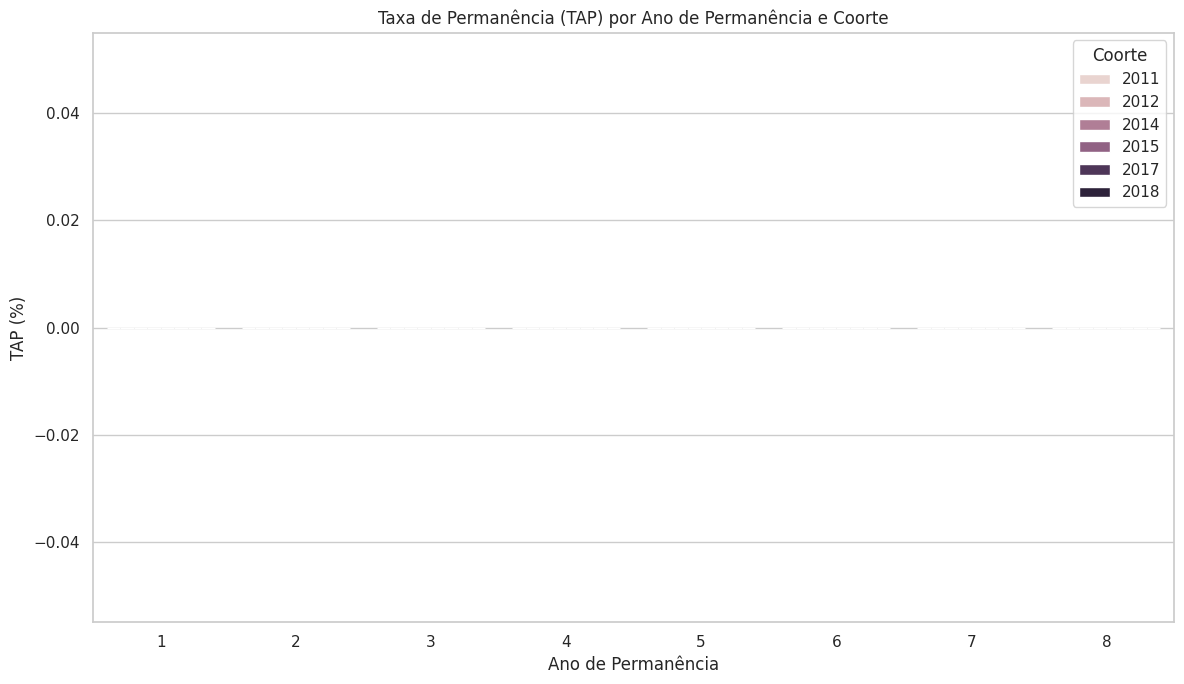

In [72]:
plot_barras(df_consolidado, 'TAP (%)', 'Taxa de Permanência (TAP) por Ano de Permanência e Coorte')


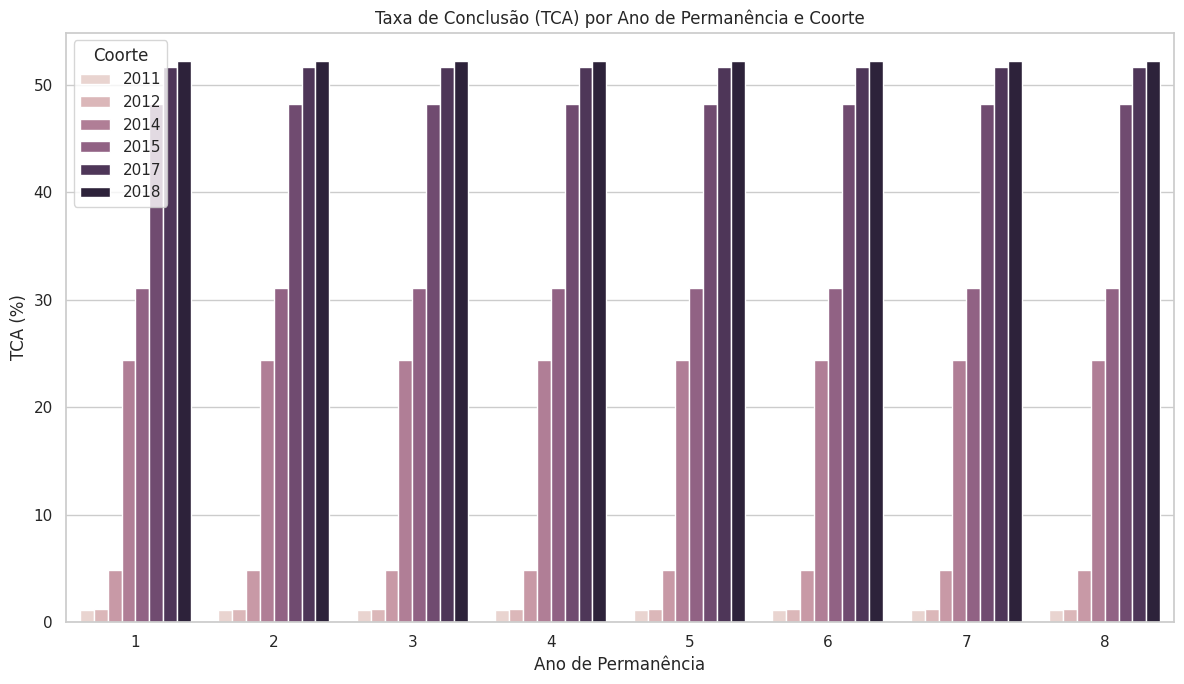

In [73]:
plot_barras(df_consolidado, 'TCA (%)', 'Taxa de Conclusão (TCA) por Ano de Permanência e Coorte')


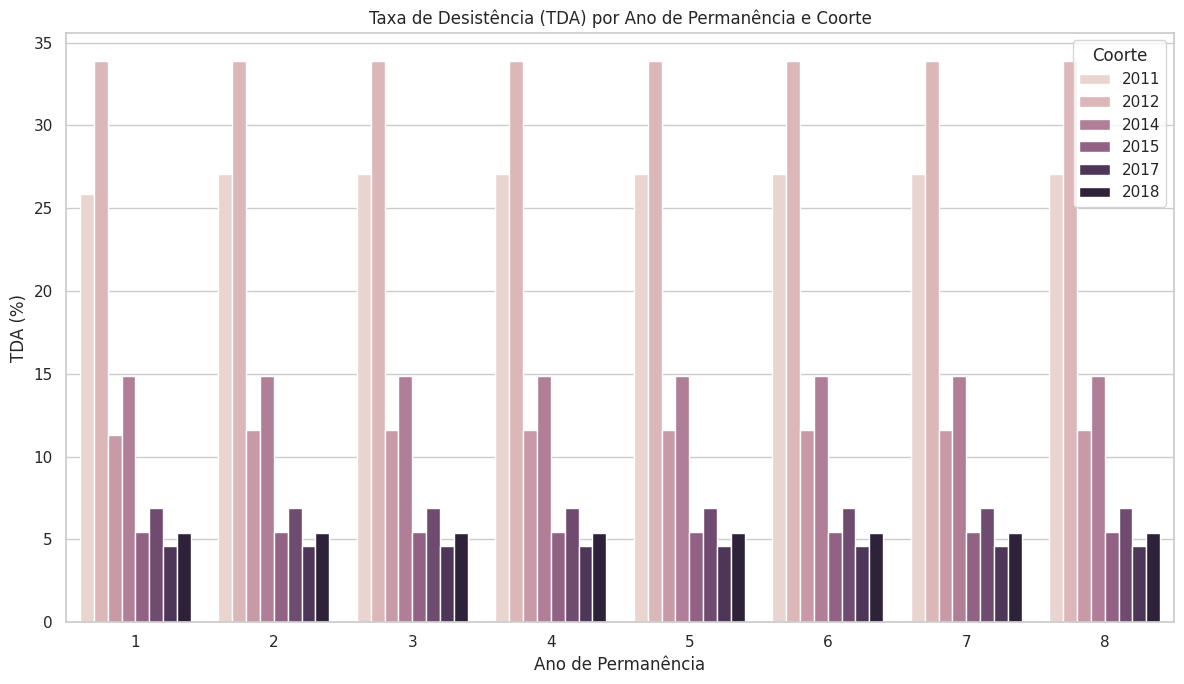

In [74]:
plot_barras(df_consolidado, 'TDA (%)', 'Taxa de Desistência (TDA) por Ano de Permanência e Coorte')


Importante descobrir em que ano o aluno entrou e saiu, saber se o motivo da saída foi desistência ou fatores externos como troca de curso, trancamento de matrícula, talvez saber em que período ocorreu a desistência seja importante, pois pode ser advindo do curso, por exemplo ter um primeiro semestre muito complicado para novatos. Minha outra pesquisa por DataSet deu como a situação financeira sendo o principal, problemas por dívidas, falta de bolsas estudantis, provavel dificuldade financeira dos pais, então acredito que essa é uma pesquisa importante a ser feita, tanto que ela é bem explorada no ENEM, com perguntas como "Quantos banheiros você tem em casa?" etc. Com a pesquisa feita nesse CSV, foi possível ver significamente o aumento da taxa de conclusão do curso e inversamente a isso, a diminuição da taxa de desistência, visto isso, seria interessante fazer uma pesquisa com alunos e outros profissionais que atuam dentro da universidade para saber a mudança que eles vêem ao longo dos anos, para ver se é algo perceptivo ou não para quem está dentro da faculdade e, se sim, de qual forma.